# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [24]:
!git clone https://github.com/japolak/datahow-course-scripts.git
!pip install --upgrade scipy==1.7.3
!cd /content/datahow-course-scripts

fatal: destination path 'datahow-course-scripts' already exists and is not an empty directory.


In [25]:
# import libaries
import pandas as pd
import numpy as np
import scipy
import importlib  
import scipy.integrate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt



# import custom modules
transformations = importlib.import_module("datahow-course-scripts.scripts.modules.transformations")
emulator = importlib.import_module("datahow-course-scripts.scripts.modules.emulator")
plothelpers = importlib.import_module("datahow-course-scripts.scripts.modules.plothelpers")

# notebook settings
pd.set_option('display.max_rows', None)

# Introduction to Cell Culture Fed-Batch Process Emulator

The emulator is aimed at providing in-silico data to test some of the machine learning tool discussed during the course. The emulator is mimicking the behavior of a fed-batch cell culture process, where only few components are present:


*   The cells, responsible for the production of the product, which are consuming glucose to sustain metabolism and producing lactate as by-product. These are indicated by VCD (viable cell density), typically expressed in million cells / ml.
*   Glucose (Glc) is consumed by the cells and it is continuously fed to the process (F_glc). Too low glucose concentrations are slowing down cell growth and product production. To high glucose concentrations are poisoning the system and accelerating cell death.
*   Lactate (Lac) is a by-product of the cells and it is poisoning the cells, so that too high lactate concentrations are slowing down cell metabolism and accelerating cell death
*   Product (Titer) is produced by the cells. The faster the cells are growing, the less are producing the product. 
*   Aggregates (Aggr) are a by-product of the process and their production is proportianal to the product concentration.

The emulator's results are based on the following equations to create the in-sillico data

### Model Equation Parameters

- Balance on VCD:  $\frac{dVCD}{dt}$ = (μ<sub>g</sub> - μ<sub>d</sub>)VCD
- Balance on Glucose: $\frac{dGlc}{dt}$ = $-k_{Glc} \frac{Glc}{Glc + 0.05}$ VCD + F<sub>Glc</sub>
- Balance on Lactate: $\frac{dLac}{dt}$ = k<sub>Lac</sub> VCD
- Balance on Product: $\frac{dProd}{dt}$ = k<sub>Prod</sub>$\frac{Glc}{Glc + K_{g, Glc} }$ ($\frac{μ_{g}}{μ_{g,max}}$)<sup>2</sup> VCD $-2 \frac{dAggr}{dt}$ 
- Balance on Aggregates: $\frac{dAggr}{dr}$ = k<sub>aggr</sub>Prod<sup>2</sup>

Where:
- Growth rate: $μ_{g} =  μ_{g,max}\frac{Glc}{Glc +K_{g, Glc}}\frac{K_{i, Lac}}{Lac+K_{i, Lac}} $
- Death rate: $μ_{d} = μ_{d,max}(1+\frac{φ}{1+φ})\frac{Lac}{Lac+K_{d, Lac}}$
- Glc saturation: φ = e<sup>0.1(Glc-75)</sup>

The user can change the different rates on the emulator, in order to change the process behavior (please use default values at the beginning)


### Process Parameters

Please insert the values of the process manipulated variables:

- Feed start (day): day at which Glc feed is started
- Feed end (day): ay at which Glc feed is stopped
- Feed rate: mass rate (g/L/day) at which Glc is feed (continuous feed over 24hours)
- Initial Glc concentration (g/L): Glc at time t = 0
- Initial VCD (10^6 cell/mL): VCD at time t = 0

## Generate Experiment Run

In [3]:
# Model parameters
mu_g_max = 0.05;
mu_d_max = 0.025;
K_g_Glc  = 1;
K_I_Lac  = 30;
K_d_Lac  = 50;
k_Glc    = 0.04;
k_Lac    = 0.06;
k_Prod   = 1;
model_param = [mu_g_max,mu_d_max,K_g_Glc,K_I_Lac,K_d_Lac,k_Glc,k_Lac,k_Prod]

# Process parameters
feed_start = 3.0
feed_end = 12.0
Glc_feed_rate = 12.0
Glc_0 = 10.0
VCD_0 = 0.3
process_param = [feed_start,feed_end,Glc_feed_rate,Glc_0,VCD_0]


In [4]:
# Experiment run generation
t,y = emulator.predict_chrom_phase(model_param,process_param)
run_df = pd.DataFrame(y,columns=["X:VCD", "X:Glc", "X:Lac", "X:Titer"])
run_df


,X:VCD,X:Glc,X:Lac,X:Titer
0,0.300000,10.000000,0.000000,0.000000
1,0.877666,9.484266,0.777573,0.129431
2,2.389344,8.030174,2.971193,0.931287
3,5.451007,4.419283,8.432332,7.038657
4,9.954081,9.171630,19.380135,32.672120
5,14.236051,9.490923,36.991679,107.606442
6,16.097601,6.789103,59.179200,249.179059
7,15.297378,3.687971,82.056450,427.837006
8,12.870307,2.335591,102.445937,595.285539
9,10.245350,3.474163,119.046093,738.830470


In [5]:
for i in ["X:VCD", "X:Glc", "X:Lac", "X:Titer"]:
    fig = px.line(run_df, x=np.array(t)/24, y=i, labels = {'x':'days'})
    fig.show()

## Generate Design of Experiments

In order to show the complexity of the model, in spite of the apparent simplicity and small number of components, in this section the user can similate the behavior of the process in a broad range of the process variables.

A number of simulations defined by "num_runs" will be generated. For this number of simulations, a latin hypercube design (LHD) is created, to uniformly map the 5-dimensional space of the variables.

### Manipulated Variables

For each of the manipulated variables defined in the section above, the use can define the limits of the exploration space (first value: lower limit; second value: upper limit).

*Note: num_runs is defining the number of simulations. The generated simulations are saved locally in the file "ExperimentsDOE_test.csv", which will be used as test set for the machine learnign tools in the followng lectures.*




In [6]:
''' DOE Dataset definition (variable = [lower bound, upper bound]) '''
# Model parameters
mu_g_max = 0.05;
mu_d_max = 0.025;
K_g_Glc  = 1;
K_I_Lac  = 30;
K_d_Lac  = 50;
k_Glc    = 0.04;
k_Lac    = 0.06;
k_Prod   = 1;

# Process parameters
feed_start = [1, 4]
feed_end = [8, 12]
Glc_feed_rate = [5, 20]
Glc_0 = [10, 80.0]
VCD_0 = [0.1, 1.0]

var_lims = {"mu_g_max":mu_g_max,
    "mu_d_max": mu_d_max,
    "K_g_Glc" : K_g_Glc,
    "K_I_Lac" : K_I_Lac,
    "K_d_Lac" : K_d_Lac,
    "k_Glc" : k_Glc,
    "k_Lac" : k_Lac,
    "k_Prod" : k_Prod,
    "feed_start" : feed_start,
    "feed_end" : feed_end,
    "Glc_feed_rate" : Glc_feed_rate,
    "Glc_0" : Glc_0,
    "VCD_0" : VCD_0}

In [7]:
## Define the number of experiments
num_runs = 100
## Define the filename for the dataset
filename = "OWUExperiments-test.csv"
# Generate DOE Dataset
owu = emulator.generate_data(var_lims, num_runs, filename)

In [8]:
# Read DOE
doe = pd.read_csv("/content/"+filename.replace(".csv","_doe_scaled.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
doe

,feed_start,feed_end,Glc_feed_rate,Glc_0,VCD_0
0,2.500000,10.000000,12.500000,45.000000,0.550000
1,3.257576,9.070707,15.075758,70.454545,0.577273
2,2.712121,8.949495,19.924242,76.818182,0.459091
3,1.954545,10.161616,12.045455,21.666667,0.977273
4,2.318182,8.424242,18.409091,59.848485,0.450000
5,2.772727,8.747475,7.651515,11.060606,0.540909
6,3.984848,11.414141,7.954545,42.878788,0.904545
7,2.954545,8.222222,7.196970,14.595960,0.877273
8,1.712121,11.131313,12.196970,61.262626,0.104545
9,1.530303,10.767677,5.984848,45.000000,0.568182


In [9]:
# Read Dataset
owu = pd.read_csv("/content/"+filename,index_col=0)
owu.columns =  ["X:VCD", "X:Glc", "X:Lac", "X:Titer"]
owu.index = pd.MultiIndex.from_product([list(range(num_runs)),list(range(15))], names=["run","time"])
owu

X:VCD         X:Glc       X:Lac      X:Titer
run time                                                  
0   0      0.550000  4.500000e+01    0.000000     0.000000
    1      1.725244  4.400819e+01    1.489389     0.054632
    2      4.779558  4.108962e+01    5.872389     1.311539
    3     10.278397  4.027148e+01   16.487303    15.870869
    4     15.886799  4.008360e+01   35.542541    85.824621
    5     18.568089  3.578307e+01   60.776450   245.221131
    6     18.099141  3.050520e+01   87.483607   468.616199
    7     15.811653  2.666724e+01  112.033694   706.666289
    8     12.920362  2.538948e+01  132.740373   924.761704
    9     10.123559  2.687354e+01  149.296217  1108.215155
    10     7.715657  3.086152e+01  162.086471  1254.876222
    11     5.775454  2.443517e+01  171.743604  1367.869866
    12     4.271029  1.965583e+01  178.928939  1452.631393
    13     3.129193  1.613956e+01  184.218131  1515.192811
    14     2.276241  1.357394e+01  188.079549  1560.822799
1   0      0.577273  7.045455e+01    0.000000     0.000000
    1      1.820233  6.940907e+01    1.569337     0.044469
    2      4.994478  6.634071e+01    6.175267     1.332361
    3     10.456131  5.905602e+01   17.111026    16.621603
    4     15.676834  5.753874e+01   36.193558    87.845636
    5     17.704940  5.631883e+01   60.658463   242.839861
    6     16.742651  5.469328e+01   85.733026   451.706188
    7     14.228508  5.484414e+01  108.140894   667.683214
    8     11.235380  5.769790e+01  126.490262   859.832607
    9      8.298567  6.342078e+01  140.531248  1014.396929
    10     5.944335  5.773160e+01  150.671367  1129.461138
    11     4.330228  5.284906e+01  158.001792  1214.159956
    12     3.173563  4.928038e+01  163.360056  1276.801331
    13     2.329729  4.666249e+01  167.290986  1323.119563
    14     1.710311  4.474061e+01  170.176959  1357.309523
2   0      0.459091  7.681818e+01    0.000000     0.000000
    1      1.458237  7.598402e+01    1.252055     0.025088
    2      4.112557  7.349127e+01    4.993692     0.760119
    3      9.024785  7.306762e+01   14.238876    10.632815
    4     13.507088  8.195748e+01   30.801043    62.072378
    5     14.043630  8.832212e+01   51.152388   175.010015
    6     11.365598  9.589992e+01   69.682139   312.524815
    7      7.869477  1.066081e+02   83.513072   431.185350
    8      4.986626  1.204372e+02   92.659906   515.748145
    9      3.018623  1.355833e+02   98.320576   570.211711
    10     1.786052  1.333265e+02  101.707023   603.510562
    11     1.043991  1.319993e+02  103.698569   623.329157
    12     0.606050  1.312262e+02  104.858645   634.951922
    13     0.350447  1.307783e+02  105.530755   641.711687
    14     0.202192  1.305196e+02  105.918963   645.624690
3   0      0.977273  2.166667e+01    0.000000     0.000000
    1      2.919724  1.994946e+01    2.582007     0.315778
    2      7.199927  1.585620e+01    9.563022     5.433059
    3     13.105156  1.820204e+01   24.153799    41.007859
    4     17.431414  1.538512e+01   46.512807   152.785826
    5     18.333194  1.006447e+01   72.665474   343.743887
    6     16.540851  5.326386e+00   98.012391   564.018746
    7     13.470560  3.102024e+00  119.691765   760.848608
    8     10.400635  3.902703e+00  136.820185   920.292890
    9      7.928800  7.283059e+00  149.943922  1054.303401
    10     6.002614  1.271489e+01  159.916707  1163.779081
    11     4.494478  9.672416e+00  167.432246  1248.644543
    12     3.310972  5.973693e+00  173.016476  1310.603076
    13     2.394932  3.283783e+00  177.096229  1353.722289
    14     1.686422  1.382230e+00  180.013485  1380.938478
4   0      0.450000  5.984848e+01    0.000000     0.000000
    1      1.427129  5.903220e+01    1.225457     0.028704
    2      4.061790  5.658310e+01    4.902284     0.770747
    3      9.120417  6.297715e+01   14.146424    10.649265
    4     14.276036  6.999224e+01   31.250159    64.383299
    5     15.884654  7.359369e+01   53.477068   191.145048
  

## Analyse single experiment

In [26]:
# Select run id to plot
selected_run_ix = 3

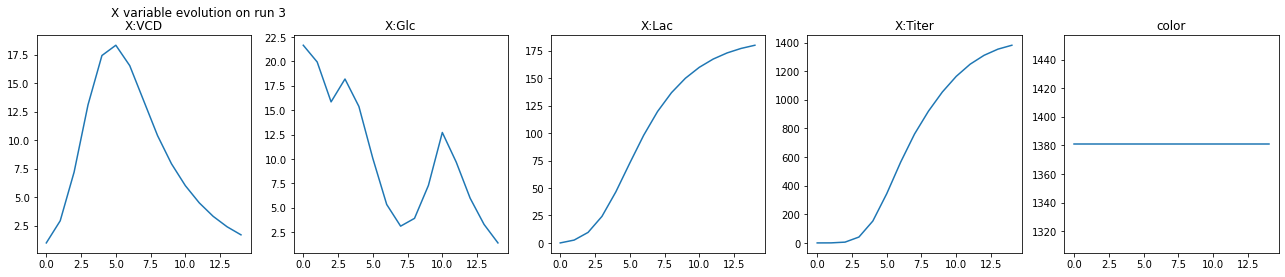

In [27]:
columns = list(owu.columns)
num_vars=len(columns)
for run_ix,run in owu.groupby("run"):
    if run_ix==selected_run_ix or (type(selected_run_ix) is list and run_ix in selected_run_ix):
        fig, axs = plt.subplots(1,num_vars)
        fig.suptitle(f'X variable evolution on run {run_ix}')
        for plot_ix, col in enumerate(columns):
            axs[ plot_ix].plot(run.index.get_level_values("time"),list(run[col].values))
            axs[ plot_ix].set_title(f'{col}')
            plt.subplots_adjust(right=3)

## Analyse all experiments

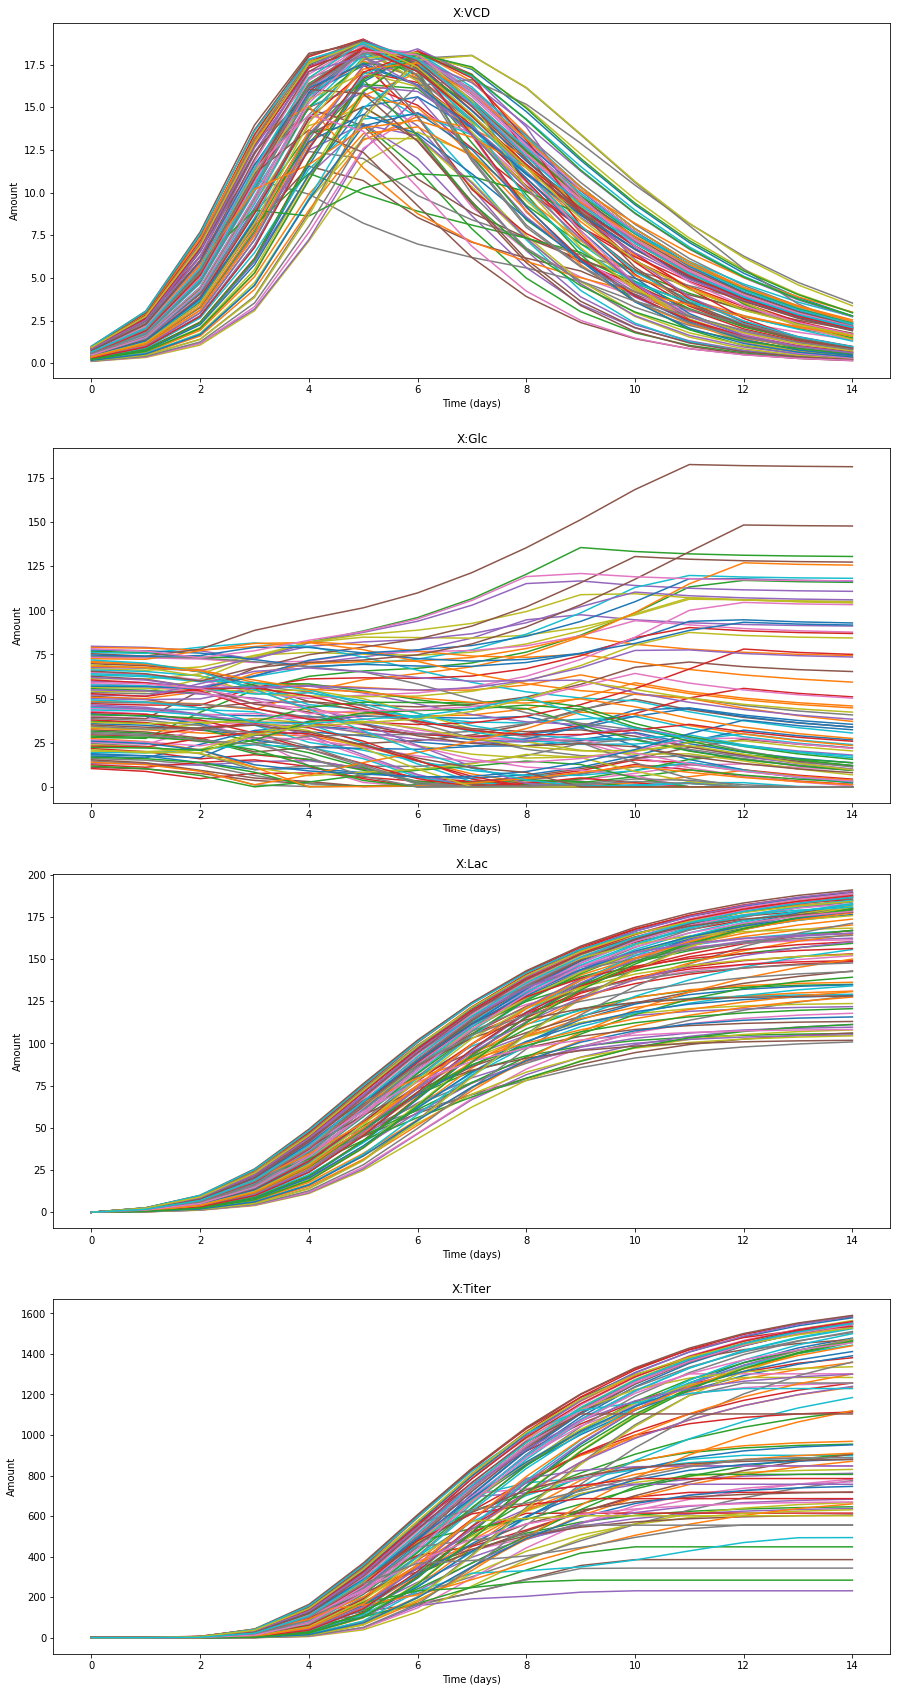

In [12]:
fig, axs = plt.subplots(num_vars,figsize=(15,30))
units_list =[""]
for run_ix,run in owu.groupby("run"):
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("time"),list(run[col].values),label=f'run {run_ix}')
        axs[ plot_ix].set_title(f'{col}')
        axs[ plot_ix].set_xlabel("Time (days)")
        axs[ plot_ix].set_ylabel("Amount")


In [13]:
# Select coloring option (Titer_14, Glc_0, VCD_0, feed_start, feed_end, Glc_feed_rate)
color_run = "Titer_14"

In [23]:
color_show=True
if color_run == "Titer_14":
    color_idx =np.repeat(np.array(owu["X:Titer"][:,14]),15)
elif color_run == "Glc_0":
    color_idx =np.repeat(np.array(owu["X:Glc"][:,0]),15)
elif color_run == "VCD_0":
    color_idx =np.repeat(np.array(owu["X:VCD"][:,0]),15)
elif color_run == "feed_start":
    color_idx =np.repeat(np.array(doe['feed_start']),15)
elif color_run == "feed_end":
    color_idx =np.repeat(np.array(doe['feed_end']),15)
elif color_run == "Glc_feed_rate":  
    color_idx =np.repeat(np.array(doe['Glc_feed_rate']),15)
else:
    color_idx=None     
    color_show=False
owu["color"] = color_idx

for i in ["X:VCD", "X:Glc", "X:Lac", "X:Titer"]:
    fig = go.Figure()
    for color_val in np.unique(color_idx):
        color_val_norm = (color_val -min(color_idx)) / (max(color_idx)-min(color_idx))
        owu_subset = owu[owu['color']==color_val]
        fig.add_trace(go.Scatter(x=owu_subset.index.get_level_values(1),y=owu_subset[i],mode='lines+markers',marker=dict(color=plothelpers.get_color('Plasma',color_val_norm))))
    fig.add_trace(go.Scatter(x=owu.index.get_level_values(1),y=owu[i],mode='markers',marker=dict(size=0,color="rgba(0,0,0,0)",colorscale='Plasma',cmin=min(color_idx),cmax=max(color_idx),colorbar=dict(thickness=40)),showlegend=False))
    fig.update_layout(showlegend=False,xaxis_title='days',yaxis_title=i, title=i)
    fig.show()

## Explore In-Silico Model Responses

Here we show how the model is reposnding to different values of glucose and lactate in order to show how such simple model is already very non-linear in the investigation space. What is plotted below are the specific effective rate of cell growth , the specific rate of glucose consumption ($\mu_g - \mu_d$), of lactate production ($k_{Glc}$), and of product production ($k_{Titer}$), as they are defined above.